# MNIST Multiclass Classification using a CNN with Keras
In this workbook, we illustrate Multi-class classification with a Keras based Convolutional Neural Network (CNN) on the MNIST digits dataset. **We will be using Tensorflow's implementation of Keras in this workbook (i.e. all Keras classes are impored from `tensorflow.keras.*` packages)**

#### <font color='firebrick'>NOTE: This notebook can work on Google Colab as well as offline with a small change</font>
* When running this notebook on Google Colab, please set `USE_COLAB=True` in cell below,  else set `USE_COLAB=False`.
* `USE_COLAB=True` will setup access to Google Drive for the current user's login (assuming she has a Google ID). 
    * Your Google Drive gets mapped to `/content/drive/My Drive`, and your Notebooks get saved to `/content/drive/My Drive/Colab Notebooks/` folder in your Google Drive. 
    * Code will add `/content/drive/My Drive/Colab Notebooks/` folder to `system.path`. Save your custom Python code files `(*.py)` here, so they are automatically added to `system.path` and you can use them in your notebook. * 
* A `MODEL_STATES` global var is created to point to the _correct_ folder where the model's state (i.e. trained weights & biases) is stored to an `.h5` file.
    * If `USE_COLAB=True`, `MODEL_STATES` maps to `/content/drive/My Drive/Colab Notebooks/model_states` folder on Google Drive.
    * Else, `MODEL_STATES` maps to `./model_states` folder on your local disk (i.e a sub-folder of folder where notebook is saved)

In [0]:
# NOTE: DO NOT set USE_COLLAB to False below. This notebook works on Google Colab ONLY!
USE_COLAB = True

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization & display a message telling you to which folder
    # your Google Drive is mapped to
    drive.mount('/content/drive/')
    print('Your notebooks on Google Drive available at /content/drive/My Drive/Colab Notebooks/')
    
    # display list of files
    #!ls '/content/drive/My Drive/Colab Notebooks/kr_helper_funcs.py'
    
    # append our Google Drive folder to module search 
    # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
    import sys
    sys.path.append("/content/drive/My Drive/Colab Notebooks/")
    # and test it
    import kr_helper_funcs as kru
    MODEL_SAVE_DIR = "/content/drive/My Drive/Colab Notebooks/model_states"
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
import os
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
Your notebooks on Google Drive available at /content/drive/My Drive/Colab Notebooks/


## About the Dataset
* The **MNIST digits dataset** is a database of handwritten digits. The latest & greatest version is [available from this page](http://yann.lecun.com/exdb/mnist/). 
* The dataset has 28x28 grayscale images of handwritten digits - 2 labelled datasets are available:
    * The _training dataset_ comprises 60,000 samples, and a _test dataset_ comprises of 10,000 samples. 
    * The digits have been size-normalized and centered in a fixed-size image.
* This is a good dataset for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on p* reprocessing and formatting.

In [0]:
import warnings
warnings.filterwarnings("ignore")

import os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
print('Using Tensorflow version ', tf.__version__)
%matplotlib inline

float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4)

plt.style.use("seaborn")

# NOTE: It is important that you set a seed value to get same results in every run.
# Any number is Ok.
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

# NOTE: I am using Tensorflow's implementation of Keras (from tf.keras)
# The API is exactly the same as Keras' API, however version may lag that on PyPl
# For Keras version implemented by Tensorflow check tf.keras.__version__
# @see: https://www.tensorflow.org/guide/keras

# Keras imports
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, 
                                     Dense, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import kr_helper_funcs as kru
print('Using Tensorflow\'s implementation of Keras version ', tf.keras.__version__)
K.clear_session()   # start afresh each time!!

Using Tensorflow version  1.14.0
Using Tensorflow's implementation of Keras version  2.2.4-tf


In [0]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10

### Loading and Pre-processing data

* **Loading**: We load the dataset from the `keras.datasets.mnist` package using the `load_data()` call. 
    * This call returns 2 sets of data - the `train` set `(X_train/y_train)` comprising 60,000 samples and the `test` set `(X_test/y_test)` comprising 10,000 samples.
* **Pre-processing**: Following pre-processing steps are applied
* Split the _test set_ into a _cross-validation_ set `(X_val/y_val)` and _test_ set, with 8,000 samples in the _cross-validation_ set and 2,000 in the test set
* Normalize the images (Xs) to values between 0-1 and one-hot-encode each label (y's) to 10 classes width
* Reshape each image file (i.e. X's) into 3D array of shape `(?,28,28,1)` 
* _NOTE:_ a non-pre-processed copy of `X_test/y_test` is also returned, used for visualization purposes only!


In [0]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    
    import seaborn as sns
  
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction (if it matches
        actual)
        or actual/prediction if there is a mismatch
    """
    assert sample_images.shape[0] == num_rows * num_cols

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="gray")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("Num %d" % sample_labels[image_index])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (true_label == pred_label)
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = "Num %d" % true_label
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = 'Num %d/%d' % (true_label, pred_label)
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

In [0]:
def load_and_preprocess_data(debug=True):
    from tensorflow.keras.datasets.mnist import load_data
    from tensorflow.keras.utils import to_categorical
    
    """
    loads the MNIST dataset from keras.datasets.mnist package
    pre-processes the image & labels data:
      - all image pixels reduced to values between 0-1
      - all labels are one-hot encoded to 10 classes
      - splits the images & labels into train/cross-validation & test sets
      - also saves a copy of non-preprocessed test set for visualization
    """

    (X_train, y_train), (X_test, y_test) = load_data()

    if debug:
        print('Before preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

    # per Andrew Ng's advise from his Structured ML course: 
    # the test & cross-validation datasets must come from the same distribution
    # So, we are going to split X_test/y_test into cross-val & test datasets 
    # (we'll use the fact that X_test/y_test is a labelled dataset to our advantage)
    # We have 10,000 samples in X_test/y_test - we'll assign 8,000 to X_val/y_val & 2,000 
    # examples to X_test/y_test (test dataset)
    
    indexes = np.arange(X_train.shape[0])
    indexes = np.random.permutation(indexes)
    X_train = X_train[indexes]
    y_train = y_train[indexes]

    indexes = np.arange(X_test.shape[0])
    for _ in range(5):
        indexes = np.random.permutation(indexes)  # shuffle 5 times!
    X_test = X_test[indexes]
    y_test = y_test[indexes]
    # val_count = int(0.20 * X_train.shape[0])
    val_count = 8000
    X_val = X_test[:val_count]
    y_val = y_test[:val_count]
    X_test = X_test[val_count:]
    y_test = y_test[val_count:]

    # keep an non pre-processed copy of X_test/y_test for visualization
    test_images, test_labels = X_test.copy(), y_test.copy()

    # scale the images to between 0-1
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    # one-hot encode labels to 10 output classes corresponding to digits 0-9
    y_train = to_categorical(y_train, 10)
    y_val = to_categorical(y_val, 10)
    y_test = to_categorical(y_test, 10)

    # reshape the image arrays (make 2D arrays instead of 3D arrays)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], NUM_CHANNELS))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], NUM_CHANNELS))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], NUM_CHANNELS))

    if debug:
        print('After preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(test_images.shape,
            test_labels.shape))

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [0]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels) = \
    load_and_preprocess_data(debug=True)

11493376/11490434 [==============================] - 0s 0us/step
Before preprocessing:
 - X_train.shape = (60000, 28, 28), y_train.shape = (60000,)
 - X_test.shape = (10000, 28, 28), y_test.shape = (10000,)
After preprocessing:
 - X_train.shape = (60000, 28, 28, 1), y_train.shape = (60000, 10)
 - X_val.shape = (8000, 28, 28, 1), y_val.shape = (8000, 10)
 - X_test.shape = (2000, 28, 28, 1), y_test.shape = (2000, 10)
 - test_images.shape = (2000, 28, 28), test_labels.shape = (2000,)


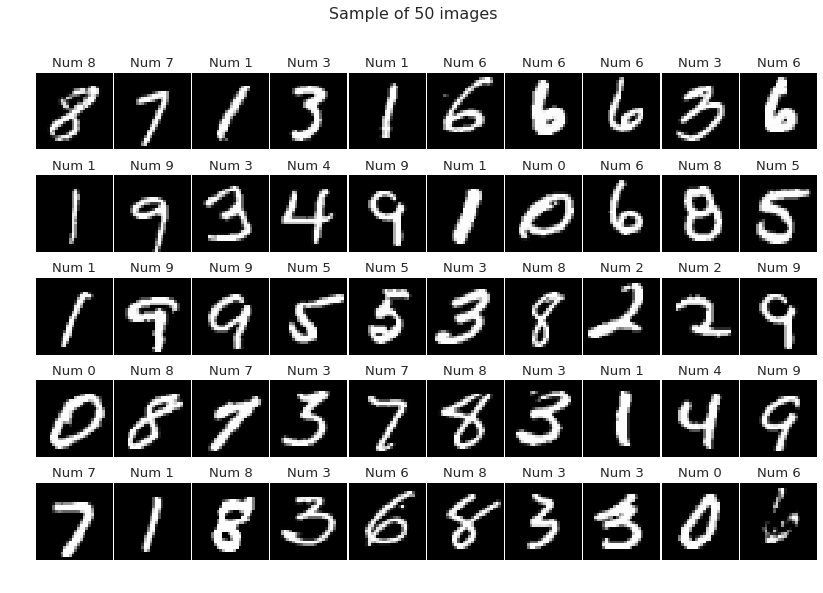

In [0]:
sample_size = 50
rand_indexes = np.random.randint(0, len(X_test), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]
display_sample(sample_images, sample_labels, plot_title='Sample of %d images' % sample_size)

## Keras Model Development

This section includes the following functions:
* `train_and_evaluate_model()` - trains model on training dataset & evaluates performance on the cross-validation dataset. Saves model to a file name on disk (Google Drive if running in Colab or directory on disk)
* `do_predictions()` - loads model state from disk and tests it on test dataset and plots predictions on a random sample of non-preprocessed data from the test set.

In [0]:
def train_and_evaluate_model(model, X_train, y_train, num_epochs=25, batch_size=32, 
                validation_data=None, plot_title=None, model_save_name=None):
    
    # train on X_train/y_train & validate against cross-validation 
    # set (X_val/y_val), if provided
    history = model.fit(X_train, y_train, epochs=num_epochs,
        batch_size=batch_size, validation_data=validation_data)
    if plot_title is not None:
        kru.show_plots(history.history, plot_title=plot_title)

    # evaluate metrics
    print("\nEvaluating...", flush=True)
    print('Training data:', flush=True)
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=1)
    print("  Training: loss %.3f - acc %.3f" % (train_loss, train_acc))

    if validation_data is not None:
        print('Cross-validation data:', flush=True)
        X_val, y_val = validation_data
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
        print("  Validation: loss %.3f - acc %.3f" % (val_loss, val_acc))
        
    if model_save_name is not None:
        kru.save_keras_model(model, model_save_name, MODEL_SAVE_DIR)

In [0]:
def load_keras_model(base_file_name, save_dir=os.path.join('.', 'keras_model_states')):
    """load model from HDF5 file"""
    if not base_file_name.lower().endswith('.h5'):
        base_file_name = base_file_name + '.h5'
        
    model_save_path = os.path.join(save_dir, base_file_name)
    if not os.path.exists(model_save_path):
        raise IOError('Cannot find file %s!' % model_save_path)
    # load the state/weights etc.
    from tensorflow.keras.models import load_model
    model = load_model(model_save_path)
    print('Loaded Keras model from %s' % model_save_path)
    return model

In [0]:
def do_predictions(model_or_file_name, X_test, y_test, test_images, test_labels, 
                   plot_title=None):
    """ run predictions on trained instance of model"""
    def test_model(model, X_test, y_test, test_images, test_labels, plot_title=None):
        print('Evaluating against test data...', flush=True)
        loss, acc = model.evaluate(X_test, y_test)
        print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

        print('Displaying sample predictions...', flush=True)
        # run predictions
        y_pred = model.predict(X_test)

        # test with 50 random images
        num_images = 50
        rand_indexes = np.random.randint(0, len(X_test), num_images)
        sample_images = test_images[rand_indexes]
        sample_labels = test_labels[rand_indexes]
        sample_predictions = np.argmax(y_pred[rand_indexes], axis=1)

        display_sample(sample_images, sample_labels, sample_predictions,
            num_rows=5, num_cols=10, plot_title=plot_title)
    
    # load the model from saved state
    if isinstance(model_or_file_name, str):
        # user provided file name where model state was saved
        # load model state from file & compile model
        model = load_keras_model(model_or_file_name, MODEL_SAVE_DIR)
    
    test_model(model, X_test, y_test, test_images, test_labels, plot_title=plot_title)
    del model

## Training Model
In this section, we will build & train several configurations of the model and evaluate performance

In [0]:
def build_model(dropout=False, l2_loss_lambda=None):
    K.clear_session()  # clear all previous states
    
    # we will use the Keras functional API to build the model

    l2 = None if l2_loss_lambda is None else regularizers.l2(l2_loss_lambda)
    if l2_loss_lambda is not None:
        print('Building model with l2-regularization = %.4f' % l2_loss_lambda, flush=True)

    inp = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))

    # convolutional layers
    A_prev = Conv2D(128, kernel_size=(3,3), padding='same', 
                    activation='relu', kernel_regularizer=l2)(inp)
    A_prev = MaxPooling2D(pool_size=(2,2)) (A_prev)
    if dropout: A_prev = Dropout(0.20) (A_prev)
        
    A_prev = Conv2D(64, kernel_size=(3,3), padding='same', 
                    activation='relu', kernel_regularizer=l2)(A_prev)
    A_prev = MaxPooling2D(pool_size=(2,2)) (A_prev)
    if dropout: A_prev = Dropout(0.10) (A_prev)
    
    A_prev = Flatten()(A_prev)
    
    # Dense layers
    A_prev = Dense(units=512, activation='relu', kernel_regularizer=l2)(A_prev)
    if dropout: A_prev = Dropout(0.20) (A_prev)

    # output layer
    out = Dense(units=NUM_CLASSES, activation='softmax')(A_prev)
    model = Model(inputs=inp, outputs=out)
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
def plot_model(model, file_name):
    from keras.utils import plot_model
    from IPython.display import Image, display
    
    try:
        # if required libraries are not setup properly, the plot_model(...) call
        # below will throw an exception. If so, we display text summary
        image_path = os.path.join(MODEL_SAVE_DIR, file_name + '.png')
        plot_model(model, show_shapes=True, show_layer_names=True, to_file=image_path)
        display(Image(image_path))
    except:
        print('Warning! Can\'t display model structure graphically. Displaying summary instead')
        print(model.summary())

### Training base model
Training a model without any regularization

In [0]:
# build & train base model
model = build_model()
#plot_model(model, 'kr_MNIST_cnn_base')
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               160614

W0618 03:39:57.822847 140489413138304 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 8000 samples
Epoch 1/25
60000/60000 [==============================] - 16s 268us/step - loss: 0.2296 - acc: 0.9358 - val_loss: 0.0698 - val_acc: 0.9771
Epoch 2/25
60000/60000 [==============================] - 12s 194us/step - loss: 0.0652 - acc: 0.9803 - val_loss: 0.0450 - val_acc: 0.9852
Epoch 3/25
60000/60000 [==============================] - 12s 194us/step - loss: 0.0438 - acc: 0.9867 - val_loss: 0.0346 - val_acc: 0.9879
Epoch 4/25
60000/60000 [==============================] - 12s 194us/step - loss: 0.0344 - acc: 0.9892 - val_loss: 0.0374 - val_acc: 0.9871
Epoch 5/25
60000/60000 [==============================] - 12s 196us/step - loss: 0.0261 - acc: 0.9918 - val_loss: 0.0358 - val_acc: 0.9884
Epoch 6/25
60000/60000 [==============================] - 12s 199us/step - loss: 0.0211 - acc: 0.9937 - val_loss: 0.0326 - val_acc: 0.9876
Epoch 7/25
60000/60000 [==============================] - 12s 193us/step - loss: 0.0166 - acc: 0.9950 - val_loss: 0.0

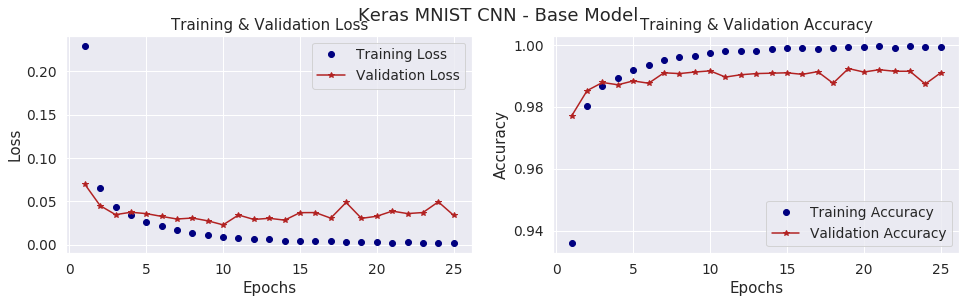


Evaluating...
Training data:
60000/60000 [==============================] - 4s 59us/step
  Training: loss 0.002 - acc 1.000
Cross-validation data:
8000/8000 [==============================] - 0s 59us/step
  Validation: loss 0.034 - acc 0.991
Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_mnist_cnn_base.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_mnist_cnn_base.h5


In [0]:
# cross-train model...
model_save_name = 'kr_mnist_cnn_base'
train_and_evaluate_model(model, X_train, y_train, validation_data=(X_val, y_val), 
                         num_epochs=25, batch_size=32, 
                         plot_title='Keras MNIST CNN - Base Model', 
                         model_save_name=model_save_name)
del model # we will load model from saved state to make predictions (as shown in next cell)

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_mnist_cnn_base.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_mnist_cnn_base.h5
Evaluating against test data...
2000/2000 [==============================] - 0s 106us/step
  - Test data: loss 0.034 - acc 0.991
Displaying sample predictions...


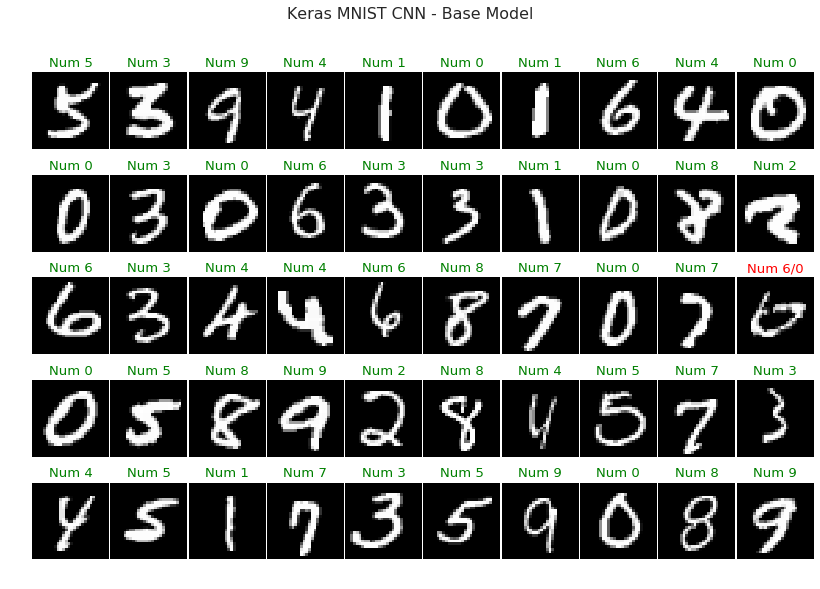

In [0]:
do_predictions('kr_mnist_cnn_base', X_test, y_test, test_images, test_labels, 
               plot_title='Keras MNIST CNN - Base Model')

#### Observation:
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99.9%|99.1%|99.1%

* Model gives very good performance - 99% accuracy on train, cross-val and test datasets
* From the prediction plot, we see model predicting all numbers correctly - no cells with red title.
   

# <center> - - END - - </center>